# Booking.com Feature Extraction
---

Download the file BookingDotCom_HotelReviews.xlsx from Canvas. This file contains over 515,000 guest reviews and rating of almost 1500 hotels across Europe scraped from popular hotel reservation website Booking.com. The text data was cleaned by removing unicode and punctuation and transformed to lower case. No other preprocessing was done. More information on each field is provided in the "Data Description" tab of the Excel file.

        1. What are the top five hotel features (e.g., location, staff, etc.) that customers mention the most in positive reviews and top five features they mention most in negative reviews? Your identified features must make sense (e.g., "great" or "negative" are not features). (3 points)
        
        2. What are the top five features that customers prefer most if they are a solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. You will find these categories in the "Tags" column. There are a few more tags that we don't need. (2 points).

        3. What are the top five features customers like most and top five features they complain about most about hotels in United Kingdom, France, Italy, and Spain? Country information is available inside Hotel_Address. (2 points)
        
        4. Create a dashboard with the following plots; (1) "Top Five Hotels Overall" with consistently high ratings, (2) Bottom Five Hotels Overall" with consistently low ratings, (3) Five Most Improved Hotels" with the highest improvement in average ratings from 2015 to 2017, showing their average ratings for each of the three years. (0.5+0.5+2 points).

Write clear, compact, and understandable code with comment/markdown statements as appropriate. Non-working code or unnecessary code will be penalized. 

Submit your Jupyter file using the link below or provide a link to your Google Colab or Github file.


In [22]:
# import packages to use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pycountry
import ast
import spacy
from sklearn.feature_extraction.text  import CountVectorizer

### Load dataframe

In [2]:
df = pd.read_excel("BookingDotCom_HotelReviews.xlsx", sheet_name="Data") # original file

# df = pd.read_csv("dfProcessed.csv") # saved from executing the steps in this notebook

# sample the first 1000 rows of df
df = df[:1500]

# rename df columns to lower case
df.columns= df.columns.str.lower()

### Remove numbers from text using regular expressions

In [3]:
df['positive_comments'] = df['positive_comments'].apply(lambda x: re.sub(r'\d+', '', str(x)))
df['negative_comments'] = df['negative_comments'].apply(lambda x: re.sub(r'\d+', '', str(x)))

### Lemmatize, remove stopwords and convert to lowercase using spaCy

In [4]:
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

# remove stopwords
myStopwords = list(load_model.Defaults.stop_words)
myStopwords.append('negative')
myStopwords.append('positive')
myStopwords.append('hotel')
#.append('positive'), 'stay', 'hotel', 'night', 'book', 'com')

def lemmaFunc(text):
    doc = load_model(text)
    allowed_tags = ['NOUN', 'PROPN']        # to get only nouns and proper nouns
    return " ".join([token.lemma_.lower() for token in doc if token.pos_ in allowed_tags \
                          and token.text.lower() not in myStopwords
                          ])

df['positive_comments'] = df['positive_comments'].apply(lambda x: lemmaFunc(x))
df['negative_comments'] = df['negative_comments'].apply(lambda x: lemmaFunc(x))

### Create a column of country names

In [63]:
# we get the list of countries from the pycountry package and use the hotel_address column to extract country name
df['country'] = df["hotel_address"].apply(
    lambda address: ' '.join([c.name for c in pycountry.countries if c.name in address])
    )

# use the review_date column to extract the year and store in new column
df['year'] = pd.DatetimeIndex(df['review_date']).year
#df['year'] = df['year'].astype(str)[:4].astype(int)

In [64]:
print(df['year'][100])

2016


### Get customer groupings from column of tags

In [6]:
'''
In this step we deal with the tags column using the steps defined below:
    1. Define tags we are interested in
    2. Define a function to apply to tags column to remove tags we are not interested in by:
            - Converting the individual row values to list (from string) e.g. "[' Leisure trip ']" -> [' leisure trip ']
            - Strip the whitespaces from individual elements e.g. [' leisure trip ']-> ['leisure trip']
            - Drop tags we are not interested in
'''

# customer tags we are interested in
customer_tags = ['solo traveler','group','business trip','leisure trip','couple','family with young children']


def clean_tag(x):

    # convert value from string to a list
    myTags = ast.literal_eval(x.lower())

    # strip whitespaces from elements and drop those we are not interested in
    myTags = [customerTag.strip() for customerTag in myTags if customerTag.strip() in customer_tags]

    return myTags

# apply clean_tag() function to the tags column
df['tags'] = df['tags'].apply(lambda x: clean_tag(x))


'''
Function applied to tags column to extract new columns for customer categories
Lambda function will be used as in the steps below
'''

def split_tag(x:list, tagName:str) -> int:
    
    t = [1 if tagName in x else 0][0]
    
    return t


# dictionary of column names (new additional columns) and customer tags (as contained in tags of interest)
tagDict = {
    'solo_traveler' : 'solo traveler',
    'group' : 'group',
    'business_trip' : 'business trip',
    'leisure_trip' : 'leisure trip',
    'couple' : 'couple',
    'family_with_young_children' : 'family with young children'
}

# applying function on tags column to get new separated columns
for key, value in tagDict.items():
    df[key] = df['tags'].apply(lambda x: split_tag(x, value))

##### Saving dataframe for future use
---

In [26]:
# df.to_csv("dfProcessed.csv", index=False)

---

### Get word frequencies using CountVectorizer from sklearn

In [7]:
vecPos = CountVectorizer(
                        strip_accents='ascii', stop_words='english',
                        analyzer='word', max_df=0.95,max_features=500
                        )

vecNeg = CountVectorizer(max_df=0.85, ngram_range=(1,2), max_features=500)

sparseVecPos = vecPos.fit_transform(df['positive_comments'])   # You can fit and transform jointly 
sparseVecNeg = vecNeg.fit_transform(df['negative_comments'])

# create dataframes from the vectors of counts
matPos = pd.DataFrame(sparseVecPos.toarray(), columns=vecPos.get_feature_names_out())
matNeg = pd.DataFrame(sparseVecNeg.toarray(), columns=vecNeg.get_feature_names_out())

### Top 5 hotel features that customers mention the most in positive reviews

In [8]:
matPos.agg(sum).sort_values(ascending=False)[:5]

room         721
staff        650
location     557
bed          294
breakfast    284
dtype: int64

### Top 5 hotel features that customers mention the most in negative reviews

In [9]:
matNeg.agg(sum).sort_values(ascending=False)[:5]

room         714
breakfast    199
staff        119
bathroom     118
night        102
dtype: int64

### Top 5 features that customers prefer most by category: solo, couple, group etc

In [10]:
# indices of customer group data subsets (by travel tag)
soloIndex = df.index[df.solo_traveler != 0] # solo_traveler
groupIndex = df.index[df.group != 0] # group
businessIndex = df.index[df.business_trip != 0] # business_trip
leisureIndex = df.index[df.leisure_trip != 0] # leisure_trip
coupleIndex = df.index[df.couple != 0] # couple
familyIndex = df.index[df.family_with_young_children != 0] # family_with_young_children

Solo

In [11]:
matPos.iloc[soloIndex].agg(sum).sort_values(ascending=False)[:5]

room         103
location     102
staff         87
breakfast     40
bed           38
dtype: int64

Group

In [12]:
matPos.iloc[groupIndex].agg(sum).sort_values(ascending=False)[:5]

room         91
staff        88
location     62
bed          40
breakfast    39
dtype: int64

Business

In [13]:
matPos.iloc[businessIndex].agg(sum).sort_values(ascending=False)[:5]

staff        81
location     80
room         79
breakfast    39
bed          26
dtype: int64

Leisure

In [14]:
matPos.iloc[leisureIndex].agg(sum).sort_values(ascending=False)[:5]

room         630
staff        558
location     471
bed          263
breakfast    239
dtype: int64

Couple

In [15]:
matPos.iloc[coupleIndex].agg(sum).sort_values(ascending=False)[:5]

room         463
staff        383
location     315
bed          192
breakfast    141
dtype: int64

Family with young children

In [16]:
matPos.iloc[familyIndex].agg(sum).sort_values(ascending=False)[:5]

staff        45
location     44
room         32
breakfast    27
bed          15
dtype: int64

### Top 5 liked/complained about features by country (UK, France, Italy, Spain)

In [17]:
# United Kingdom likes/complaints
print("\nLiked: \n", matPos.iloc[df.index[df.country == 'United Kingdom']].agg(sum).sort_values(ascending=False)[:5])
print("\nComplained about:\n", matNeg.iloc[df.index[df.country == 'United Kingdom']].agg(sum).sort_values(ascending=False)[:5])


Liked: 
 room         526
staff        489
location     466
breakfast    242
bed          198
dtype: int64

Complained about:
 room         440
breakfast    159
staff         81
bathroom      63
time          60
dtype: int64


In [18]:
# France likes/complaints
print(matPos.iloc[df.index[df.country == 'France']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matNeg.iloc[df.index[df.country == 'France']].agg(sum).sort_values(ascending=False)[:5])

access       0.0
product      0.0
range        0.0
railway      0.0
quietness    0.0
dtype: float64


ac                0.0
renovation        0.0
room breakfast    0.0
room bit          0.0
room bed          0.0
dtype: float64


In [19]:
# Italy likes/complaints
print(matPos.iloc[df.index[df.country == 'Italy']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matNeg.iloc[df.index[df.country == 'Italy']].agg(sum).sort_values(ascending=False)[:5])

access       0.0
product      0.0
range        0.0
railway      0.0
quietness    0.0
dtype: float64


ac                0.0
renovation        0.0
room breakfast    0.0
room bit          0.0
room bed          0.0
dtype: float64


In [20]:
# Spain likes/complaints
print(matPos.iloc[df.index[df.country == 'Spain']].agg(sum).sort_values(ascending=False)[:5])
print('\n')
print(matPos.iloc[df.index[df.country == 'Spain']].agg(sum).sort_values(ascending=False)[:5])

access       0.0
product      0.0
range        0.0
railway      0.0
quietness    0.0
dtype: float64


access       0.0
product      0.0
range        0.0
railway      0.0
quietness    0.0
dtype: float64


### Top 5 Hotels Overall with consistently high ratings

In [24]:
overallRatings = df[['hotel_name', 'average_hotel_score']].groupby(['hotel_name']).mean()

Text(0.5, 1.0, 'Top 5 Hotels Overall')

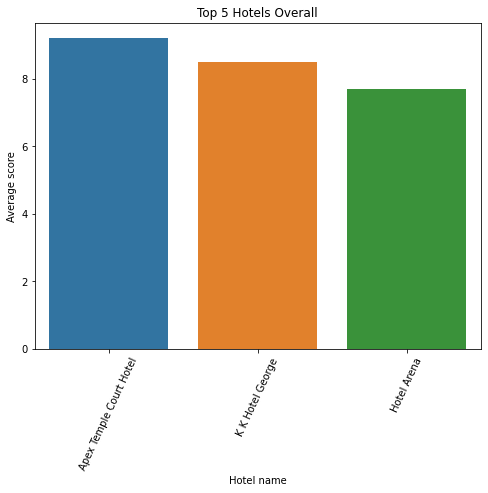

In [35]:
# top 5 hotels
topOverall = overallRatings.sort_values(by=['average_hotel_score'], ascending=False)[:5].reset_index()

plt.figure(figsize=(8,6))

x_labels = list(topOverall.hotel_name)

fig = sns.barplot(
    data=topOverall, 
    x='hotel_name', y='average_hotel_score', 
    errorbar=None)
plt.xlabel('Hotel name')
plt.ylabel('Average score')
plt.xticks(rotation=65)
plt.title('Top 5 Hotels Overall')

### Bottom 5 Hotels Overall with consistently low ratings

Text(0.5, 1.0, 'Bottom 5 Hotels Overall')

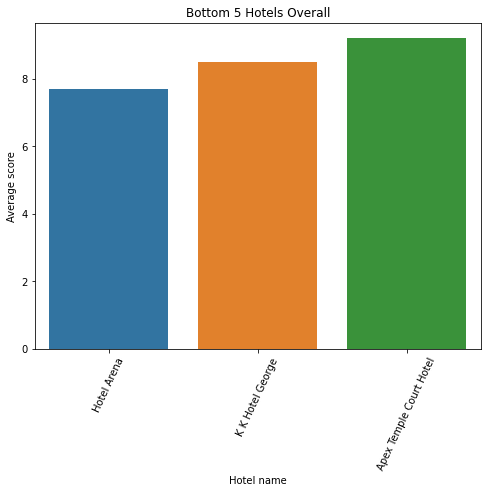

In [36]:
bottomOverall = overallRatings.sort_values(by=['average_hotel_score'])[:5].reset_index()

plt.figure(figsize=(8,6))

x_labels = list(bottomOverall.hotel_name)

fig = sns.barplot(
    data=bottomOverall, 
    x='hotel_name', y='average_hotel_score', 
    errorbar=None)
plt.xlabel('Hotel name')
plt.ylabel('Average score')
plt.xticks(rotation=65)
plt.title('Bottom 5 Hotels Overall')

### 5 most improved hotels with the highest improvement in average ratings from 2015 to 2017 
showing their average ratings for each of the 3 years

In [56]:
df.head(3)

,hotel_name,hotel_address,review_count,non_review_scoring_count,average_hotel_score,review_date,reviewer_nationality,positive_comments,negative_comments,total_reviewer_reviews,reviewer_score,tags,country,year,solo_traveler,group,business_trip,leisure_trip,couple,family_with_young_children
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,park,post site trip mistake place booking com night...,7,2.9,"[leisure trip, couple]",Netherlands,2017.0,0,0,0,1,1,0
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,complaint location surrounding amenity service...,,7,7.5,"[leisure trip, couple]",Netherlands,2017.0,0,0,0,1,1,0
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,location staff breakfast range,room bit room story step level room tea coffee...,9,7.1,"[leisure trip, family with young children]",Netherlands,2017.0,0,0,0,1,0,1


In [55]:
improvement = df[['hotel_name', 'reviewer_score', 'year']].groupby(['hotel_name']).mean().reset_index()
improvement.head()

,hotel_name,reviewer_score,year
0,Apex Temple Court Hotel,9.230246,NaN
1,Hotel Arena,7.836296,2017.0
2,K K Hotel George,8.602827,NaN
